In [1]:
!python -m spacy download pt_core_news_sm
!pip install googletrans==4.0.0-rc1
!pip install enelvo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 29.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.9 MB/s eta 0

In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from google.colab import drive
from googletrans import Translator
from enelvo.normaliser import Normaliser
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Concatenate, Input, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import spacy
import time
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Pré-processamento

## 0) Base de Dados

In [4]:
norm = Normaliser(tokenizer='readable')
chats_clients = pd.read_csv('/content/drive/Shareddrives/grupo3moshi/augmented_data.csv')
chats_clients.head()

,No,Intencao,Pergunta,Resposta
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...


In [5]:
chats_clients.fillna('erro ao processar a pergunta', inplace=True)

In [6]:
nlp_pt = spacy.load("pt_core_news_sm")

In [7]:
def correct_grammar(text):
  return norm.normalise(text)

## 1) Word2Vec

O processo de Word2Vec é uma técnica de aprendizado de máquina com o objetivo de vetorizar palavras almejando preservar o contexto, convertendo o resultado para a forma numérica, para que os dados possam ser utilizados em modelos de aprendizado de máquina.

O Word2Vec pode possuir 2 arquiteturas, sendo elas:

- Skip-Gram: rede tenta prever as palavras de contexto ao redor de uma palavra central
- CBOW: rede tenta prever a palavra central com base no contexto ao redor da palavra central.

Para fins de comparação, ambas as técnicas serão abordadas no código a seguir:

### 1.1) Skip-Gram

In [8]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Tokenizando as colunas
chats_clients['Pergunta_tokens'] = chats_clients['Pergunta'].apply(lambda x: word_tokenize(x.lower()))
chats_clients['Resposta_tokens'] = chats_clients['Resposta'].apply(lambda x: word_tokenize(x.lower()))

# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_skip = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model = Word2Vec(sentences_skip, vector_size=100, window=5, min_count=1, sg=1)  #sg=1 para Skip-Gram

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 1.2) Resultados Obtidos

In [9]:
# Acessando o vetor de uma palavra
vector_dia_skip = model.wv['dia']
print(vector_dia_skip)

[-0.49805918  0.48370302 -0.2696646  -0.06490531  0.01172676 -0.02771715
 -0.10791659  0.36009082 -0.24327518 -0.07242882 -0.13701743 -0.10024545
 -0.10211741 -0.09918074  0.22566949  0.08323614  0.56570923  0.18372199
 -0.13895665 -0.27956     0.5304564   0.07629944  0.42030987 -0.05400607
  0.15183406  0.46509942 -0.13155596 -0.41440624 -0.2937022   0.09995492
  0.33225453  0.1134065  -0.14731522  0.35233328  0.0742178   0.17600621
 -0.21948361 -0.38479668 -0.33252713 -0.1571174   0.16859868 -0.14150654
  0.03738189 -0.0009324  -0.13206072 -0.25337392 -0.1953435  -0.00707653
  0.17722277 -0.20561312  0.01458399 -0.15387253 -0.14479047 -0.18298583
 -0.12653448 -0.1939583   0.20847163  0.18059112  0.29098502 -0.04888419
  0.09117258  0.16359559  0.18862426  0.11171124  0.34381783  0.18498206
 -0.01745209  0.28421536 -0.26226464  0.09178539 -0.01965897 -0.34789214
 -0.016586    0.0113346   0.10700934  0.12550962  0.08833977  0.00967244
 -0.30783165  0.27290392 -0.29186493 -0.3463364   0

In [10]:
# Encontrando palavras similares
similar_words_dia_skip = model.wv.most_similar('dia')
print(similar_words_dia_skip)

[('especial', 0.7657853960990906), ('plantão', 0.73338383436203), ('sim', 0.6801781058311462), ('cai', 0.6748289465904236), ('quantas', 0.6723310351371765), ('27/05', 0.6698616147041321), ('poi', 0.6694502830505371), ('realizei', 0.6694259643554688), ('nova', 0.6685649752616882), ('!', 0.6673237085342407)]


In [11]:
# Encontrando palavras similares
similar_words_bom_skip = model.wv.most_similar('bom')
print(similar_words_bom_skip)

[('!', 0.789310097694397), ('especial', 0.7096955180168152), ('plantão', 0.6920182108879089), ('aparecida', 0.6918244957923889), ('sim', 0.6887344717979431), ('nova', 0.6883372068405151), ('conforme', 0.6870719194412231), ('processaremos', 0.6795158982276917), ('após', 0.6767751574516296), ('mensagem', 0.6762786507606506)]


In [12]:
# Encontrando palavras similares
similar_words_dinheiro_skip = model.wv.most_similar('dinheiro')
print(similar_words_dinheiro_skip)

[('japão', 0.8712978363037109), ('enviam', 0.864630401134491), ('belem', 0.8315919637680054), ('poder', 0.829551637172699), ('tempo', 0.8283659219741821), ('pace', 0.8173667788505554), ('levará', 0.8151895403862), ('pacing', 0.8102962374687195), ('leva', 0.8028998970985413), ('pro', 0.8011928200721741)]


In [13]:
# Encontrando palavras similares
similar_words_pix_skip = model.wv.most_similar('pix')
print(similar_words_pix_skip)

[('sendo', 0.9735804200172424), ('via', 0.9725015759468079), ('feitos', 0.9721224904060364), ('realizadas', 0.9631917476654053), ('pagamentos', 0.9525603652000427), ('estão', 0.9259819984436035), ('maioria', 0.913944661617279), ('pagas', 0.9128751754760742), ('pagos', 0.9064093232154846), ('chegam', 0.9049512147903442)]


### 2.1) CBOW

In [14]:
# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_CBOW = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model_cbow = Word2Vec(sentences_CBOW, vector_size=100, window=5, min_count=1, sg=0)  #sg=0 para CBOW

### 2.2) Resultados Obtidos

In [15]:
# Acessando o vetor de uma palavra
vector_dia_cbow = model_cbow.wv['dia']
print(vector_dia_cbow)

[-3.83845538e-01  2.98888892e-01 -4.49530035e-01 -7.50662014e-03
  3.43410313e-01 -3.86455178e-01 -1.34823054e-01  1.12266409e+00
 -2.66723633e-01 -3.74826878e-01 -4.79304790e-01 -5.99396408e-01
 -5.15181780e-01  4.75693107e-01  3.78083140e-01  1.55591667e-01
  3.23772341e-01  2.83578128e-01 -1.69749230e-01 -3.09193969e-01
  5.98306060e-01  3.36184740e-01  8.23325336e-01 -8.42718631e-02
  1.30115852e-01  1.95186362e-01 -1.26202628e-01 -3.34952712e-01
 -3.08889002e-01  4.94948894e-01  8.01338136e-01 -1.21908866e-01
  7.90555403e-03  5.29323891e-02 -1.32827774e-01  4.76251245e-01
 -3.62825133e-02 -4.39887553e-01 -4.81053919e-01 -2.21080527e-01
  2.59944528e-01 -2.12460980e-02 -5.69025159e-01 -6.31229132e-02
  2.32412398e-01  2.83077627e-01 -2.02348083e-01 -2.40452439e-01
  2.06437841e-01 -4.81901526e-01  4.89408940e-01 -5.97830236e-01
 -4.54498172e-01 -4.52085435e-01 -2.28795201e-01 -3.14723283e-01
  1.84034660e-01  1.53937116e-02 -1.07228696e-01  9.59437266e-02
 -6.53098300e-02  8.05433

In [16]:
# Encontrando palavras similares
similar_words_dia_cbow = model_cbow.wv.most_similar('dia')
print(similar_words_dia_cbow)

[('bom', 0.9698780179023743), ('olá', 0.9675793647766113), ('noite', 0.957078218460083), ('uma', 0.9423054456710815), ('tira', 0.9418728351593018), ('sim', 0.941238284111023), ('boa', 0.9394519329071045), ('!', 0.9388893842697144), ('td', 0.9349736571311951), ('oi', 0.9347749352455139)]


In [17]:
# Encontrando palavras similares
similar_words_bom_cbow = model_cbow.wv.most_similar('bom')
print(similar_words_bom_cbow)

[('!', 0.9709985852241516), ('dia', 0.9698778986930847), ('noite', 0.9645791053771973), ('boa', 0.9621525406837463), ('informar', 0.9563647508621216), ('feather', 0.9481023550033569), ('olá', 0.9448467493057251), ('uma', 0.9415271282196045), ('tarde', 0.9408660531044006), ('aguardar', 0.939717173576355)]


In [18]:
# Encontrando palavras similares
similar_words_dinheiro_cbow = model_cbow.wv.most_similar('dinheiro')
print(similar_words_dinheiro_cbow)

[('japão', 0.9936719536781311), ('?', 0.9806187152862549), ('levará', 0.9742901921272278), ('tempo', 0.9716808199882507), ('enviar', 0.9703329205513), ('pra', 0.9580184817314148), ('enviou', 0.9563267827033997), ('volta', 0.9510916471481323), ('cair', 0.9470417499542236), ('mandar', 0.9420952200889587)]


In [19]:
# Encontrando palavras similares
similar_words_pix_cbow = model_cbow.wv.most_similar('pix')
print(similar_words_pix_cbow)

[('via', 0.9938480854034424), ('feitos', 0.9811408519744873), ('sendo', 0.9713488221168518), ('pagamentos', 0.9657948613166809), ('realizadas', 0.9608134627342224), ('estão', 0.9599854946136475), ('pagas', 0.9281427264213562), ('chegam', 0.8759945631027222), ('apta', 0.8748621344566345), ('dentro', 0.8572518229484558)]


### 3.1) Word Embedding


Dessa forma, é fundamental gerar os embedding das colunas para que futuros modelos de aprendizado de máquina possam compreender e utilizar os dados de cada frase. Para tal, será utilizado uma média dos vetores de cada frase, desenvolvido a seguir, utilizando a abordagem CBOW (padrão):


In [20]:
import numpy as np

# Função para gerar o embedding médio de uma frase
def get_sentence_embedding(tokens, model):
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

### 3.2) Resultados Obtidos

In [21]:
# Aplicando a função para gerar os embeddings e salvando nas novas colunas
chats_clients['Pergunta_embedding'] = chats_clients['Pergunta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))
chats_clients['Resposta_embedding'] = chats_clients['Resposta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))

In [22]:
chats_clients['Pergunta_embedding'].head()

,Pergunta_embedding
0,"[-0.24188922, 0.23124357, -0.25568798, -0.0369..."
1,"[-0.4973855, 0.21124148, -0.5408675, -0.128682..."
2,"[-0.4892066, 0.27118888, -0.43885145, -0.05697..."
3,"[-0.17460139, 0.2049126, -0.19432998, -0.00894..."
4,"[-0.223547, 0.28521234, -0.17608233, -0.014630..."


In [23]:
chats_clients['Resposta_embedding'].head()

,Resposta_embedding
0,"[-0.27719533, 0.21802114, -0.20653659, -0.0214..."
1,"[-0.40732235, 0.5017779, -0.18504585, -0.03974..."
2,"[-0.4845146, 0.4166981, -0.29839417, -0.070443..."
3,"[-0.2056257, 0.43954542, -0.04538771, 0.075350..."
4,"[-0.2056257, 0.43954542, -0.04538771, 0.075350..."


## 2) Base de Dados Final

In [24]:
chats_clients

,No,Intencao,Pergunta,Resposta,Pergunta_tokens,Resposta_tokens,Pergunta_embedding,Resposta_embedding
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d...","[boa, dia.tudo, bem, ?, eu, gostaria, de, sabe...","[bom, dia, !, sim, ,, o, sr, pode, utilizar, o...","[-0.24188922, 0.23124357, -0.25568798, -0.0369...","[-0.27719533, 0.21802114, -0.20653659, -0.0214..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f...","[como, enviar, dinheiro, do, japão, ?]","[para, se, inscrever, no, serviço, de, remessa...","[-0.4973855, 0.21124148, -0.5408675, -0.128682...","[-0.40732235, 0.5017779, -0.18504585, -0.03974..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ...","[quanto, tempo, levará, para, o, beneficiário,...","[via, de, regra, ,, as, remessas, serão, pagas...","[-0.4892066, 0.27118888, -0.43885145, -0.05697...","[-0.4845146, 0.4166981, -0.29839417, -0.070443..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...,"[boa, tarde, acabei, de, fazer, a, transferênc...","[iremos, processar, a, sua, solicitacao, ., mu...","[-0.17460139, 0.2049126, -0.19432998, -0.00894...","[-0.2056257, 0.43954542, -0.04538771, 0.075350..."
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...,"[poderia, fazer, a, remessa, de, 22yenes, para...","[iremos, processar, a, sua, solicitacao, ., mu...","[-0.223547, 0.28521234, -0.17608233, -0.014630...","[-0.2056257, 0.43954542, -0.04538771, 0.075350..."
...,...,...,...,...,...,...,...,...
1510,501,Atualizacao de dados cadastrais,boa tarde como faço paratrooper fazer a mudanç...,vitamin A senhora pode trocar pelo próprio app...,"[boa, tarde, como, faço, paratrooper, fazer, a...","[vitamin, a, senhora, pode, trocar, pelo, próp...","[-0.20373353, 0.19987656, -0.24722242, -0.0204...","[-0.32607168, 0.43081892, -0.018135317, -0.153..."
1511,502,Tempo de entrega do cartao,Bom dia Consegui fazer depósito sem group O ca...,feather boa noite O sr solicitou dia 28. Será ...,"[bom, dia, consegui, fazer, depósito, sem, gro...","[feather, boa, noite, o, sr, solicitou, dia, 2...","[-0.3175839, 0.24062483, -0.23386855, -0.03056...","[-0.25768274, 0.27313456, -0.18091434, -0.0137..."
1512,503,Cancelamento,"feather boa noite,a beneficiária me avisou que...","Sim, podemos cancelar O valiancy voltará no se...","[feather, boa, noite, ,, a, beneficiária, me, ...","[sim, ,, podemos, cancelar, o, valiancy, volta...","[-0.2825378, 0.26632065, -0.24002601, -0.03517...","[-0.35688785, 0.22191668, -0.24560346, -0.0495..."
1513,504,Reembolso,"Boa noite Europe fiz um depósito errado, era p...",É possível solicitar o reembolso diretamente d...,"[boa, noite, europe, fiz, um, depósito, errado...","[é, possível, solicitar, o, reembolso, diretam...","[-0.34158477, 0.25569794, -0.28084615, -0.0363...","[-0.30059537, 0.40508488, -0.13909872, -0.0415..."


### Classificador de intenção

O classificador de intenção é um sistema que identifica a intenção por trás de uma mensagem de texto, neste caso, seria as mensagens (entradas do chatbot) enviadas pelos clientes. A intenção refere-se ao que o usuário deseja realizar, como transferir dinheiro, taxa de câmbio, etc.
Nesta seção é abordado o treinamento do modelo com suas respectivas métricas (Acurácia, Recall, F1-Score).

Abaixo há uma classe de callback que guarda as métricas de F1-Score e recall. A F1-score é uma métrica que leva em consideração a precisão e o recall, sendo definida pela seguinte fórmula:
$$ F1-Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

F1 é conhecido como a média harmônica da precisão e do recall. A pontuação F1 se torna 1 apenas se a precisão e recall são 1. Se a precisão e o recall são altos, logo o valor de F1 também é alta.

a métrica Recall (sensibilidade) ajuda a avaliar a capacidade do modelo de identificar corretamente todos os exemplos positivos de uma classe. Por exemplo, se temos um problema onde devemos classificar com uma classificação "sim" ou "não" referente a spam de e-mails, o recall nesse caso nos dirá quantos e-mails de spam o modelo conseguiu identificar corretamente, dentre todos os e-mails que realmente eram spam.

A fórmula do recall é a seguinte:

$$ Recall = \frac{TP}{TP + FN}$$

Já a acurácia é a proporção total de exemplos que o modelo classificou corretamente, ou seja, o quanto o modelo conseguiu acertar. Fórmula:


$$ Recall = \frac{Previsões corretas}{Previsões incorretas}$$

In [25]:
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = np.argmax(self.model.predict(val_data), axis=1)
        val_f1 = f1_score(val_labels, val_pred, average='macro')
        recall = recall_score(val_labels, val_pred, average='macro', zero_division=1)
        print(f'Epoch {epoch + 1}: f1-score: {val_f1:.4f} - recall: {recall:.4f}')
        logs['f1_score'] = val_f1
        logs['recall'] = recall

In [26]:
class IntentClassifier:
    def __init__(self, epochs=180, batch_size=16, test_size=0.4, validation_split=0.4, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())
        response_embeddings = np.array(chats_clients['Resposta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        combined_embeddings = np.stack((answer_embeddings, response_embeddings), axis=1)
        X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        self.model.add(Dropout(0.5))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train(self, X_train, X_test, y_train, y_test):
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           early_stopping,
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

      ### Entender o problema abaixo

        # precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes)

        # report_df = pd.DataFrame({
        #     'Class': self.label_encoder.classes_,
        #     'Precision': precision,
        #     'Recall': recall,
        #     'F1-Score': f1,
        #     'Support': support
        # })

        # report_df.loc['Average'] = report_df[['Precision', 'Recall', 'F1-Score', 'Support']].mean()
        # report_df.loc['Average', 'Class'] = 'Average'

        # print(report_df)


### Treino e avaliação com CPU

Para rodar o modelo com a CPU basta alocar qualquer máquina do colab, rodar todas as células anteriores e rodar a célula abaixo.

In [27]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
with tf.device('/cpu:0'):
  # Calcula o tempo da cpu
  start_time = time.time()
  classifier.train(X_train, X_test, y_train, y_test)
  # Para o cronômetro e salva o tempo da cpu
  time_cpu = time.time() - start_time

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 2, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │             594 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,506 (1.23 MB)

 Trainable params: 323,506 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/180


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1: f1-score: 0.0238 - recall: 0.0588
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.2132 - loss: 2.8341 - val_accuracy: 0.2143 - val_loss: 2.5371 - f1_score: 0.0238 - recall: 0.0588
Epoch 2/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3226 - loss: 2.4202

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step
Epoch 2: f1-score: 0.1158 - recall: 0.1609
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.3232 - loss: 2.4185 - val_accuracy: 0.4396 - val_loss: 2.1170 - f1_score: 0.1158 - recall: 0.1609
Epoch 3/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 3: f1-score: 0.1290 - recall: 0.1672
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.3716 - loss: 2.2241 - val_accuracy: 0.4615 - val_loss: 1.9203 - f1_score: 0.1290 - recall: 0.1672
Epoch 4/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 4: f1-score: 0.1416 - recall: 0.1858
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.4441 - loss: 1.9757 - val_accuracy: 0.4945 - val_loss: 1.7519 - f1_score: 0.1416 - recall: 0.1858
Epoch 5/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 5: f1-score: 0.1502 - recall: 0.1919
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.4706 - loss: 1.8368 - val_accuracy: 0.4835 - val_loss: 1.6798 - f1_score: 0.1502 - recall: 0.1919
Epoch 6/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 6: f1-score: 0.1636 - recall: 0.2161
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.5063 - loss: 1.6538 - val_accuracy: 0.4973 - val_loss: 1.6475 - f1_score: 0.1636 - recall: 0.2161
Epoch 7/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 7: f1-score: 0.1739 - recall: 0.2271
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.5076 - loss: 1.6533 - val_accuracy: 0.5440 - val_loss: 1.5943 - f1_score: 0.1739 - recall: 0.2271
Epoch 8/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 8: f1-score: 0.1711 - recall: 0.2193
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.5263 - loss: 1.5807 - val_accuracy: 0.5137 - val_loss: 1.5521 - f1_score: 0.1711 - recall: 0.2193
Epoch 9/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 9: f1-score: 0.1727 - recall: 0.2210
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.5068 - loss: 1.5605 - val_accuracy: 0.5275 - val_loss: 1.5200 - f1_score: 0.1727 - recall: 0.2210
Epoch 10/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 10: f1-score: 0.1781 - recall: 0.2259
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.4967 - loss: 1.6049 - val_accuracy: 0.5385 - val_loss: 1.4911 - f1_score: 0.1781 - recall: 0.2259
Epoch 11/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 11: f1-score: 0.1823 - recall: 0.2226
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.5269 - loss: 1.5604 - val_accuracy: 0.5220 - val_loss: 1.5144 - f1_score: 0.1823 - recall: 0.2226
Epoch 12/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 12: f1-score: 0.1870 - recall: 0.2302
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.4904 - loss: 1.6345 - val_accuracy: 0.5247 - val_loss: 1.5494 - f1_score: 0.1870 - recall: 0.2302
Epoch 13/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 13: f1-score: 0.2025 - recall: 0.2532
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.5037 - loss: 1.5718 - val_accuracy: 0.5495 - val_loss: 1.4390 - f1_score: 0.2025 - recall: 0.2532
Epoch 14/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 14: f1-score: 0.1969 - recall: 0.2408
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.5585 - loss: 1.4285 - val_accuracy: 0.5495 - val_loss: 1.4170 - f1_score: 0.1969 - recall: 0.2408
Epoch 15/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 15: f1-score: 0.2128 - recall: 0.2608
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.5182 - loss: 1.5053 - val_accuracy: 0.5522 - val_loss: 1.4041 - f1_score: 0.2128 - recall: 0.2608
Epoch 16/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Epoch 16: f1-score: 0.2193 - recall: 0.2683
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.5466 - loss: 1.4682 - val_accuracy: 0.5522 - val_loss: 1.4309 - f1_score: 0.2193 - recall: 0.2683
Epoch 17/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 17: f1-score: 0.2441 - recall: 0.2792
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.5434 - loss: 1.4497 - val_accuracy: 0.5659 - val_loss: 1.3653 - f1_score: 0.2441 - recall: 0.2792
Epoch 18/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 18: f1-score: 0.2514 - recall: 0.2838
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.5813 - loss: 1.3087 - val_accuracy: 0.5879 - val_loss: 1.3706 - f1_score: 0.2514 - recall: 0.2838
Epoch 19/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 19: f1-score: 0.2587 - recall: 0.2899
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.5420 - loss: 1.3672 - val_accuracy: 0.5852 - val_loss: 1.3280 - f1_score: 0.2587 - recall: 0.2899
Epoch 20/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 20: f1-score: 0.2451 - recall: 0.2839
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.6147 - loss: 1.2707 - val_accuracy: 0.5769 - val_loss: 1.3687 - f1_score: 0.2451 - recall: 0.2839
Epoch 21/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Epoch 21: f1-score: 0.2786 - recall: 0.3102
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.5473 - loss: 1.3942 - val_accuracy: 0.5934 - val_loss: 1.2901 - f1_score: 0.2786 - recall: 0.3102
Epoch 22/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 22: f1-score: 0.2734 - recall: 0.3090
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.5717 - loss: 1.3006 - val_accuracy: 0.5907 - val_loss: 1.3798 - f1_score: 0.2734 - recall: 0.3090
Epoch 23/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 23: f1-score: 0.2641 - recall: 0.2785
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.6122 - loss: 1.2474 - val_accuracy: 0.5852 - val_loss: 1.3447 - f1_score: 0.2641 - recall: 0.2785
Epoch 24/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 24: f1-score: 0.2841 - recall: 0.3029
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.6023 - loss: 1.2300 - val_accuracy: 0.5742 - val_loss: 1.3112 - f1_score: 0.2841 - recall: 0.3029
Epoch 25/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 25: f1-score: 0.2783 - recall: 0.3153
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.5790 - loss: 1.2869 - val_accuracy: 0.6319 - val_loss: 1.2523 - f1_score: 0.2783 - recall: 0.3153
Epoch 26/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 26: f1-score: 0.2573 - recall: 0.2966
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.4910 - loss: 1.5035 - val_accuracy: 0.5962 - val_loss: 1.3370 - f1_score: 0.2573 - recall: 0.2966
Epoch 27/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 27: f1-score: 0.2959 - recall: 0.3400
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.5898 - loss: 1.2894 - val_accuracy: 0.6044 - val_loss: 1.2645 - f1_score: 0.2959 - recall: 0.3400
Epoch 28/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 28: f1-score: 0.3013 - recall: 0.3499
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.5868 - loss: 1.2262 - val_accuracy: 0.5989 - val_loss: 1.2409 - f1_score: 0.3013 - recall: 0.3499
Epoch 29/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 29: f1-score: 0.2980 - recall: 0.3171
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.5783 - loss: 1.2664 - val_accuracy: 0.5989 - val_loss: 1.2704 - f1_score: 0.2980 - recall: 0.3171
Epoch 30/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Epoch 30: f1-score: 0.3087 - recall: 0.3424
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.5908 - loss: 1.2383 - val_accuracy: 0.6126 - val_loss: 1.2612 - f1_score: 0.3087 - recall: 0.3424
Epoch 31/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 31: f1-score: 0.3041 - recall: 0.3515
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.6059 - loss: 1.2315 - val_accuracy: 0.6016 - val_loss: 1.2285 - f1_score: 0.3041 - recall: 0.3515
Epoch 32/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 32: f1-score: 0.3096 - recall: 0.3269
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.5868 - loss: 1.2936 - val_accuracy: 0.6099 - val_loss: 1.2200 - f1_score: 0.3096 - recall: 0.3269
Epoch 33/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 33: f1-score: 0.3184 - recall: 0.3597
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.6113 - loss: 1.2069 - val_accuracy: 0.6264 - val_loss: 1.2085 - f1_score: 0.3184 - recall: 0.3597
Epoch 34/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 34: f1-score: 0.3239 - recall: 0.3618
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.5991 - loss: 1.2149 - val_accuracy: 0.6456 - val_loss: 1.1676 - f1_score: 0.3239 - recall: 0.3618
Epoch 35/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 35: f1-score: 0.3253 - recall: 0.3409
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.6236 - loss: 1.1638 - val_accuracy: 0.6346 - val_loss: 1.2279 - f1_score: 0.3253 - recall: 0.3409
Epoch 36/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 36: f1-score: 0.3020 - recall: 0.3429
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.5992 - loss: 1.2828 - val_accuracy: 0.6429 - val_loss: 1.2142 - f1_score: 0.3020 - recall: 0.3429
Epoch 37/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 37: f1-score: 0.3461 - recall: 0.3863
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5918 - loss: 1.1637 - val_accuracy: 0.6566 - val_loss: 1.1753 - f1_score: 0.3461 - recall: 0.3863
Epoch 38/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 38: f1-score: 0.3441 - recall: 0.3897
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.6223 - loss: 1.1033 - val_accuracy: 0.6484 - val_loss: 1.1684 - f1_score: 0.3441 - recall: 0.3897
Epoch 39/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 39: f1-score: 0.3633 - recall: 0.3812
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.6228 - loss: 1.1199 - val_accuracy: 0.6484 - val_loss: 1.1884 - f1_score: 0.3633 - recall: 0.3812
Epoch 40/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 40: f1-score: 0.3471 - recall: 0.3866
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.6232 - loss: 1.1195 - val_accuracy: 0.6456 - val_loss: 1.1621 - f1_score: 0.3471 - recall: 0.3866
Epoch 41/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Epoch 41: f1-score: 0.3454 - recall: 0.3679
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.6559 - loss: 1.1158 - val_accuracy: 0.6429 - val_loss: 1.1775 - f1_score: 0.3454 - recall: 0.3679
Epoch 42/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 42: f1-score: 0.3675 - recall: 0.4507
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.6244 - loss: 1.1546 - val_accuracy: 0.6456 - val_loss: 1.1488 - f1_score: 0.3675 - recall: 0.4507
Epoch 43/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 43: f1-score: 0.3434 - recall: 0.3900
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.5995 - loss: 1.2171 - val_accuracy: 0.6374 - val_loss: 1.1723 - f1_score: 0.3434 - recall: 0.3900
Epoch 44/180
 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Epoch 44: f1-score: 0.3733 - recall: 0.4090
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.6362 - loss: 1.0647 - val_accuracy: 0.6538 - val_loss: 1.1229 - f1_score: 0.3733 - recall: 0.4090
Epoch 45/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 45: f1-score: 0.3696 - recall: 0.4488
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.6730 - loss: 1.0097 - val_accuracy: 0.6511 - val_loss: 1.1199 - f1_score: 0.3696 - recall: 0.4488
Epoch 46/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 46: f1-score: 0.3702 - recall: 0.4088
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.6111 - loss: 1.1742 - val_accuracy: 0.6484 - val_loss: 1.1272 - f1_score: 0.3702 - recall: 0.4088
Epoch 47/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 47: f1-score: 0.3634 - recall: 0.4340
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.6162 - loss: 1.1058 - val_accuracy: 0.6593 - val_loss: 1.1401 - f1_score: 0.3634 - recall: 0.4340
Epoch 48/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 48: f1-score: 0.3917 - recall: 0.4072
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.6049 - loss: 1.1707 - val_accuracy: 0.6429 - val_loss: 1.1561 - f1_score: 0.3917 - recall: 0.4072
Epoch 49/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 49: f1-score: 0.3986 - recall: 0.4337
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.6410 - loss: 1.1405 - val_accuracy: 0.6538 - val_loss: 1.1168 - f1_score: 0.3986 - recall: 0.4337
Epoch 50/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Epoch 50: f1-score: 0.3593 - recall: 0.4530
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.6571 - loss: 1.0614 - val_accuracy: 0.6703 - val_loss: 1.1022 - f1_score: 0.3593 - recall: 0.4530
Epoch 51/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 51: f1-score: 0.3725 - recall: 0.4507
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.6664 - loss: 1.0256 - val_accuracy: 0.6566 - val_loss: 1.1120 - f1_score: 0.3725 - recall: 0.4507
Epoch 52/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 52: f1-score: 0.3756 - recall: 0.4006
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.6638 - loss: 1.0969 - val_accuracy: 0.6401 - val_loss: 1.1266 - f1_score: 0.3756 - recall: 0.4006
Epoch 53/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 53: f1-score: 0.3818 - recall: 0.4609
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.6461 - loss: 1.0558 - val_accuracy: 0.6566 - val_loss: 1.1018 - f1_score: 0.3818 - recall: 0.4609
Epoch 54/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 54: f1-score: 0.3874 - recall: 0.4613
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.7016 - loss: 0.9427 - val_accuracy: 0.6593 - val_loss: 1.1152 - f1_score: 0.3874 - recall: 0.4613
Epoch 55/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 55: f1-score: 0.4025 - recall: 0.4769
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.6426 - loss: 1.0903 - val_accuracy: 0.6868 - val_loss: 1.0944 - f1_score: 0.4025 - recall: 0.4769
Epoch 56/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 56: f1-score: 0.4023 - recall: 0.4287
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.6746 - loss: 0.9191 - val_accuracy: 0.6484 - val_loss: 1.1040 - f1_score: 0.4023 - recall: 0.4287
Epoch 57/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 57: f1-score: 0.3793 - recall: 0.4512
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.6566 - loss: 1.0411 - val_accuracy: 0.6566 - val_loss: 1.0989 - f1_score: 0.3793 - recall: 0.4512
Epoch 58/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 58: f1-score: 0.4168 - recall: 0.4497
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.6016 - loss: 1.1157 - val_accuracy: 0.6813 - val_loss: 1.0717 - f1_score: 0.4168 - recall: 0.4497
Epoch 59/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 59: f1-score: 0.4078 - recall: 0.4352
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.6708 - loss: 0.9465 - val_accuracy: 0.6813 - val_loss: 1.0411 - f1_score: 0.4078 - recall: 0.4352
Epoch 60/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 60: f1-score: 0.4550 - recall: 0.4712
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.6652 - loss: 0.9766 - val_accuracy: 0.6896 - val_loss: 1.0362 - f1_score: 0.4550 - recall: 0.4712
Epoch 61/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 61: f1-score: 0.4288 - recall: 0.4997
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.6873 - loss: 0.9067 - val_accuracy: 0.6813 - val_loss: 1.0424 - f1_score: 0.4288 - recall: 0.4997
Epoch 62/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 62: f1-score: 0.4354 - recall: 0.5045
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.6668 - loss: 1.0992 - val_accuracy: 0.6621 - val_loss: 1.0997 - f1_score: 0.4354 - recall: 0.5045
Epoch 63/180
 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Epoch 63: f1-score: 0.4506 - recall: 0.5096
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.6865 - loss: 0.9318 - val_accuracy: 0.6868 - val_loss: 1.0345 - f1_score: 0.4506 - recall: 0.5096
Epoch 64/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 64: f1-score: 0.4634 - recall: 0.5200
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.7030 - loss: 0.8561 - val_accuracy: 0.6841 - val_loss: 1.0504 - f1_score: 0.4634 - recall: 0.5200
Epoch 65/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 65: f1-score: 0.4130 - recall: 0.4796
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.6845 - loss: 0.8584 - val_accuracy: 0.6731 - val_loss: 1.1066 - f1_score: 0.4130 - recall: 0.4796
Epoch 66/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 66: f1-score: 0.4403 - recall: 0.5056
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.7081 - loss: 0.8460 - val_accuracy: 0.6648 - val_loss: 1.0932 - f1_score: 0.4403 - recall: 0.5056
Epoch 67/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 67: f1-score: 0.4032 - recall: 0.4767
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.7039 - loss: 0.8964 - val_accuracy: 0.6511 - val_loss: 1.2214 - f1_score: 0.4032 - recall: 0.4767
Epoch 68/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 68: f1-score: 0.4662 - recall: 0.5320
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.6757 - loss: 1.0321 - val_accuracy: 0.6923 - val_loss: 1.0555 - f1_score: 0.4662 - recall: 0.5320
Epoch 69/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 69: f1-score: 0.4800 - recall: 0.4920
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.7430 - loss: 0.8102 - val_accuracy: 0.7115 - val_loss: 1.0489 - f1_score: 0.4800 - recall: 0.4920
Epoch 70/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 70: f1-score: 0.5158 - recall: 0.5211
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.7264 - loss: 0.8714 - val_accuracy: 0.6868 - val_loss: 0.9920 - f1_score: 0.5158 - recall: 0.5211
Epoch 71/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 71: f1-score: 0.5178 - recall: 0.5751
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.7447 - loss: 0.7565 - val_accuracy: 0.7033 - val_loss: 1.0133 - f1_score: 0.5178 - recall: 0.5751
Epoch 72/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Epoch 72: f1-score: 0.4730 - recall: 0.5582
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.6860 - loss: 0.9077 - val_accuracy: 0.7060 - val_loss: 1.0545 - f1_score: 0.4730 - recall: 0.5582
Epoch 73/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 73: f1-score: 0.4832 - recall: 0.5503
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.7390 - loss: 0.7914 - val_accuracy: 0.6868 - val_loss: 1.0594 - f1_score: 0.4832 - recall: 0.5503
Epoch 74/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 74: f1-score: 0.4797 - recall: 0.5616
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.6942 - loss: 0.8287 - val_accuracy: 0.6951 - val_loss: 1.0328 - f1_score: 0.4797 - recall: 0.5616
Epoch 75/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 75: f1-score: 0.4996 - recall: 0.5813
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.7083 - loss: 0.8695 - val_accuracy: 0.7005 - val_loss: 1.0729 - f1_score: 0.4996 - recall: 0.5813
Epoch 76/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 76: f1-score: 0.5216 - recall: 0.5898
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.7314 - loss: 0.7978 - val_accuracy: 0.7335 - val_loss: 1.0010 - f1_score: 0.5216 - recall: 0.5898
Epoch 77/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 77: f1-score: 0.5060 - recall: 0.5964
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.7304 - loss: 0.7828 - val_accuracy: 0.6868 - val_loss: 1.1187 - f1_score: 0.5060 - recall: 0.5964
Epoch 78/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 78: f1-score: 0.4233 - recall: 0.5376
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.6348 - loss: 1.0697 - val_accuracy: 0.6511 - val_loss: 1.0910 - f1_score: 0.4233 - recall: 0.5376
Epoch 79/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 79: f1-score: 0.5104 - recall: 0.5570
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.7150 - loss: 0.8084 - val_accuracy: 0.6813 - val_loss: 1.0333 - f1_score: 0.5104 - recall: 0.5570
Epoch 80/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 80: f1-score: 0.4907 - recall: 0.5642
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.7311 - loss: 0.7986 - val_accuracy: 0.6896 - val_loss: 1.0660 - f1_score: 0.4907 - recall: 0.5642
Epoch 81/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 81: f1-score: 0.4950 - recall: 0.5630
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.7406 - loss: 0.7020 - val_accuracy: 0.7088 - val_loss: 1.0057 - f1_score: 0.4950 - recall: 0.5630
Epoch 82/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 82: f1-score: 0.5093 - recall: 0.5978
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.7548 - loss: 0.7241 - val_accuracy: 0.7225 - val_loss: 0.9875 - f1_score: 0.5093 - recall: 0.5978
Epoch 83/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 83: f1-score: 0.5309 - recall: 0.6269
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.7774 - loss: 0.6332 - val_accuracy: 0.7335 - val_loss: 1.0133 - f1_score: 0.5309 - recall: 0.6269
Epoch 84/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 84: f1-score: 0.5057 - recall: 0.6064
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.7041 - loss: 0.8972 - val_accuracy: 0.7280 - val_loss: 0.9575 - f1_score: 0.5057 - recall: 0.6064
Epoch 85/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Epoch 85: f1-score: 0.5412 - recall: 0.6195
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.7082 - loss: 0.8130 - val_accuracy: 0.7198 - val_loss: 0.9800 - f1_score: 0.5412 - recall: 0.6195
Epoch 86/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 86: f1-score: 0.4984 - recall: 0.5863
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7830 - loss: 0.6859 - val_accuracy: 0.7225 - val_loss: 1.0204 - f1_score: 0.4984 - recall: 0.5863
Epoch 87/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 87: f1-score: 0.5345 - recall: 0.6225
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.7720 - loss: 0.7157 - val_accuracy: 0.6923 - val_loss: 1.0124 - f1_score: 0.5345 - recall: 0.6225
Epoch 88/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 88: f1-score: 0.5624 - recall: 0.5896
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.7886 - loss: 0.6904 - val_accuracy: 0.6951 - val_loss: 1.0371 - f1_score: 0.5624 - recall: 0.5896
Epoch 89/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 89: f1-score: 0.5415 - recall: 0.6217
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.7662 - loss: 0.6545 - val_accuracy: 0.7280 - val_loss: 1.0118 - f1_score: 0.5415 - recall: 0.6217
Epoch 90/180
 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 90: f1-score: 0.5597 - recall: 0.5844
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.7871 - loss: 0.6622 - val_accuracy: 0.7225 - val_loss: 1.0071 - f1_score: 0.5597 - recall: 0.5844
Epoch 91/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 91: f1-score: 0.5271 - recall: 0.6153
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.7501 - loss: 0.7356 - val_accuracy: 0.7198 - val_loss: 1.0524 - f1_score: 0.5271 - recall: 0.6153
Epoch 92/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 92: f1-score: 0.5173 - recall: 0.6155
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.7686 - loss: 0.6722 - val_accuracy: 0.7170 - val_loss: 1.0270 - f1_score: 0.5173 - recall: 0.6155
Epoch 93/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 93: f1-score: 0.5614 - recall: 0.6340
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.7603 - loss: 0.6635 - val_accuracy: 0.7610 - val_loss: 0.9682 - f1_score: 0.5614 - recall: 0.6340
Epoch 94/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Epoch 94: f1-score: 0.5130 - recall: 0.5737
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.7795 - loss: 0.6144 - val_accuracy: 0.7335 - val_loss: 1.0626 - f1_score: 0.5130 - recall: 0.5737
Epoch 95/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 95: f1-score: 0.5221 - recall: 0.5895
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7578 - loss: 0.7027 - val_accuracy: 0.7473 - val_loss: 1.0096 - f1_score: 0.5221 - recall: 0.5895
Epoch 96/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 96: f1-score: 0.5909 - recall: 0.6168
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.7513 - loss: 0.7852 - val_accuracy: 0.7280 - val_loss: 0.9831 - f1_score: 0.5909 - recall: 0.6168
Epoch 97/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 97: f1-score: 0.5238 - recall: 0.5485
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.7297 - loss: 0.7964 - val_accuracy: 0.7280 - val_loss: 1.0083 - f1_score: 0.5238 - recall: 0.5485
Epoch 98/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 98: f1-score: 0.5204 - recall: 0.6175
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.7465 - loss: 0.7517 - val_accuracy: 0.7363 - val_loss: 0.9492 - f1_score: 0.5204 - recall: 0.6175
Epoch 99/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 99: f1-score: 0.5379 - recall: 0.6167
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.7855 - loss: 0.6627 - val_accuracy: 0.7390 - val_loss: 0.9549 - f1_score: 0.5379 - recall: 0.6167
Epoch 100/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 100: f1-score: 0.5385 - recall: 0.6293
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.7681 - loss: 0.6612 - val_accuracy: 0.7390 - val_loss: 0.9499 - f1_score: 0.5385 - recall: 0.6293
Epoch 101/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 101: f1-score: 0.5435 - recall: 0.6423
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.7721 - loss: 0.6249 - val_accuracy: 0.7390 - val_loss: 0.9703 - f1_score: 0.5435 - recall: 0.6423
Epoch 102/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Epoch 102: f1-score: 0.5649 - recall: 0.6391
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - accuracy: 0.8005 - loss: 0.6227 - val_accuracy: 0.7473 - val_loss: 0.9790 - f1_score: 0.5649 - recall: 0.6391
Epoch 103/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Epoch 103: f1-score: 0.5360 - recall: 0.6216
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.7819 - loss: 0.6008 - val_accuracy: 0.7418 - val_loss: 1.0028 - f1_score: 0.5360 - recall: 0.6216
Epoch 104/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 104: f1-score: 0.5509 - recall: 0.6403
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.8110 - loss: 0.5268 - val_accuracy: 0.7500 - val_loss: 0.9755 - f1_score: 0.5509 - recall: 0.6403
Epoch 105/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 105: f1-score: 0.5331 - recall: 0.6162
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.7891 - loss: 0.5542 - val_accuracy: 0.7363 - val_loss: 0.9907 - f1_score: 0.5331 - recall: 0.6162
Epoch 106/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 106: f1-score: 0.5346 - recall: 0.6184
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.8417 - loss: 0.5054 - val_accuracy: 0.7308 - val_loss: 1.0783 - f1_score: 0.5346 - recall: 0.6184
Epoch 107/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 107: f1-score: 0.5394 - recall: 0.6320
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.8183 - loss: 0.5743 - val_accuracy: 0.7418 - val_loss: 0.9904 - f1_score: 0.5394 - recall: 0.6320
Epoch 108/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 108: f1-score: 0.5328 - recall: 0.6225
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.7858 - loss: 0.5827 - val_accuracy: 0.7747 - val_loss: 0.9920 - f1_score: 0.5328 - recall: 0.6225
Epoch 109/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 109: f1-score: 0.5466 - recall: 0.6396
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.8053 - loss: 0.5788 - val_accuracy: 0.7692 - val_loss: 0.9811 - f1_score: 0.5466 - recall: 0.6396
Epoch 110/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 110: f1-score: 0.5014 - recall: 0.5988
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.7942 - loss: 0.5854 - val_accuracy: 0.7253 - val_loss: 1.1233 - f1_score: 0.5014 - recall: 0.5988
Epoch 111/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 111: f1-score: 0.5208 - recall: 0.6190
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.7863 - loss: 0.6163 - val_accuracy: 0.7527 - val_loss: 1.0047 - f1_score: 0.5208 - recall: 0.6190
Epoch 112/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Epoch 112: f1-score: 0.5334 - recall: 0.6029
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.8083 - loss: 0.5514 - val_accuracy: 0.7500 - val_loss: 1.0135 - f1_score: 0.5334 - recall: 0.6029
Epoch 113/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 113: f1-score: 0.5489 - recall: 0.6148
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.8256 - loss: 0.5300 - val_accuracy: 0.7582 - val_loss: 1.0654 - f1_score: 0.5489 - recall: 0.6148
Epoch 114/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 114: f1-score: 0.5888 - recall: 0.6306
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.7920 - loss: 0.5777 - val_accuracy: 0.7692 - val_loss: 1.0144 - f1_score: 0.5888 - recall: 0.6306
Epoch 115/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Epoch 115: f1-score: 0.5459 - recall: 0.6482
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.8093 - loss: 0.5126 - val_accuracy: 0.7500 - val_loss: 1.0815 - f1_score: 0.5459 - recall: 0.6482
Epoch 116/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 116: f1-score: 0.5799 - recall: 0.6711
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.7801 - loss: 0.5791 - val_accuracy: 0.7527 - val_loss: 1.0220 - f1_score: 0.5799 - recall: 0.6711
Epoch 117/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 117: f1-score: 0.5867 - recall: 0.6686
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.8232 - loss: 0.5049 - val_accuracy: 0.7747 - val_loss: 0.9874 - f1_score: 0.5867 - recall: 0.6686
Epoch 118/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 118: f1-score: 0.5662 - recall: 0.6209
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.8178 - loss: 0.5207 - val_accuracy: 0.7445 - val_loss: 0.9938 - f1_score: 0.5662 - recall: 0.6209
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6944 - loss: 1.0867

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6992 - loss: 1.0508
Test Loss: 1.0713367462158203, Test Accuracy: 0.6914191246032715


### Treino e avaliação com GPU

Para rodar o modelo com a GPU é necessário alocar uma máquina com GPU, por exemplo a T4 GPU, rodar todas as células anteriores (exceto a de treino com CPU que não é necessária) , e rodar a célula abaixo.

In [28]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
with tf.device('/gpu:0'):
  # Calcula o tempo da gpu
  start_time = time.time()
  classifier.train(X_train, X_test, y_train, y_test)
  # Para o cronômetro e salva o tempo da gpu
  time_gpu = time.time() - start_time

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 2, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 18)                  │             594 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,506 (1.23 MB)

 Trainable params: 323,506 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/180


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1: f1-score: 0.0238 - recall: 0.0588
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.2258 - loss: 2.8081 - val_accuracy: 0.2143 - val_loss: 2.5893 - f1_score: 0.0238 - recall: 0.0588
Epoch 2/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 2: f1-score: 0.0697 - recall: 0.1113
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.2405 - loss: 2.5140 - val_accuracy: 0.3242 - val_loss: 2.1842 - f1_score: 0.0697 - recall: 0.1113
Epoch 3/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 3: f1-score: 0.1109 - recall: 0.1644
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4212 - loss: 2.1134 - val_accuracy: 0.4478 - val_loss: 1.8568 - f1_score: 0.1109 - recall: 0.1644
Epoch 4/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 4: f1-score: 0.1319 - recall: 0.1827
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.4414 - loss: 1.9594 - val_accuracy: 0.4643 - val_loss: 1.7398 - f1_score: 0.1319 - recall: 0.1827
Epoch 5/180
 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Epoch 5: f1-score: 0.1533 - recall: 0.1960
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.4957 - loss: 1.7461 - val_accuracy: 0.4918 - val_loss: 1.6880 - f1_score: 0.1533 - recall: 0.1960
Epoch 6/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 6: f1-score: 0.1431 - recall: 0.1896
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.4862 - loss: 1.7559 - val_accuracy: 0.4588 - val_loss: 1.7314 - f1_score: 0.1431 - recall: 0.1896
Epoch 7/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Epoch 7: f1-score: 0.1736 - recall: 0.2242
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.4702 - loss: 1.7718 - val_accuracy: 0.5082 - val_loss: 1.6723 - f1_score: 0.1736 - recall: 0.2242
Epoch 8/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 8: f1-score: 0.1817 - recall: 0.2366
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.4787 - loss: 1.8019 - val_accuracy: 0.5577 - val_loss: 1.5878 - f1_score: 0.1817 - recall: 0.2366
Epoch 9/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 9: f1-score: 0.1719 - recall: 0.2290
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.5540 - loss: 1.5245 - val_accuracy: 0.5165 - val_loss: 1.5883 - f1_score: 0.1719 - recall: 0.2290
Epoch 10/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Epoch 10: f1-score: 0.1858 - recall: 0.2276
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.5270 - loss: 1.5437 - val_accuracy: 0.5275 - val_loss: 1.5301 - f1_score: 0.1858 - recall: 0.2276
Epoch 11/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 11: f1-score: 0.1900 - recall: 0.2371
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.5423 - loss: 1.5179 - val_accuracy: 0.5495 - val_loss: 1.5041 - f1_score: 0.1900 - recall: 0.2371
Epoch 12/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Epoch 12: f1-score: 0.2089 - recall: 0.2477
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.5294 - loss: 1.5093 - val_accuracy: 0.5577 - val_loss: 1.4514 - f1_score: 0.2089 - recall: 0.2477
Epoch 13/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 13: f1-score: 0.2055 - recall: 0.2475
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.5564 - loss: 1.4926 - val_accuracy: 0.5687 - val_loss: 1.4327 - f1_score: 0.2055 - recall: 0.2475
Epoch 14/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 14: f1-score: 0.2001 - recall: 0.2438
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.5184 - loss: 1.5306 - val_accuracy: 0.5522 - val_loss: 1.4322 - f1_score: 0.2001 - recall: 0.2438
Epoch 15/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 15: f1-score: 0.2030 - recall: 0.2454
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.5548 - loss: 1.4065 - val_accuracy: 0.5577 - val_loss: 1.3994 - f1_score: 0.2030 - recall: 0.2454
Epoch 16/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 16: f1-score: 0.2167 - recall: 0.2595
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5482 - loss: 1.4131 - val_accuracy: 0.5714 - val_loss: 1.3674 - f1_score: 0.2167 - recall: 0.2595
Epoch 17/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 17: f1-score: 0.2475 - recall: 0.2764
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.5685 - loss: 1.3144 - val_accuracy: 0.5769 - val_loss: 1.3387 - f1_score: 0.2475 - recall: 0.2764
Epoch 18/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Epoch 18: f1-score: 0.2338 - recall: 0.2666
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.5569 - loss: 1.4254 - val_accuracy: 0.5742 - val_loss: 1.3182 - f1_score: 0.2338 - recall: 0.2666
Epoch 19/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 19: f1-score: 0.2419 - recall: 0.2711
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.5795 - loss: 1.2992 - val_accuracy: 0.5742 - val_loss: 1.3630 - f1_score: 0.2419 - recall: 0.2711
Epoch 20/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Epoch 20: f1-score: 0.2576 - recall: 0.2869
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.5619 - loss: 1.3868 - val_accuracy: 0.5769 - val_loss: 1.3049 - f1_score: 0.2576 - recall: 0.2869
Epoch 21/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 21: f1-score: 0.2744 - recall: 0.3017
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.5828 - loss: 1.3032 - val_accuracy: 0.5852 - val_loss: 1.3031 - f1_score: 0.2744 - recall: 0.3017
Epoch 22/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 22: f1-score: 0.2701 - recall: 0.3099
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.5897 - loss: 1.2710 - val_accuracy: 0.5989 - val_loss: 1.2640 - f1_score: 0.2701 - recall: 0.3099
Epoch 23/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 23: f1-score: 0.2790 - recall: 0.3025
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5787 - loss: 1.3011 - val_accuracy: 0.5797 - val_loss: 1.2571 - f1_score: 0.2790 - recall: 0.3025
Epoch 24/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 24: f1-score: 0.2842 - recall: 0.3154
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.5997 - loss: 1.3373 - val_accuracy: 0.5934 - val_loss: 1.2374 - f1_score: 0.2842 - recall: 0.3154
Epoch 25/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 25: f1-score: 0.2834 - recall: 0.3163
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.6013 - loss: 1.3385 - val_accuracy: 0.5852 - val_loss: 1.2530 - f1_score: 0.2834 - recall: 0.3163
Epoch 26/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 26: f1-score: 0.3056 - recall: 0.3338
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.5532 - loss: 1.3504 - val_accuracy: 0.6181 - val_loss: 1.2168 - f1_score: 0.3056 - recall: 0.3338
Epoch 27/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 27: f1-score: 0.3068 - recall: 0.3268
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.5968 - loss: 1.2196 - val_accuracy: 0.6099 - val_loss: 1.2254 - f1_score: 0.3068 - recall: 0.3268
Epoch 28/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 28: f1-score: 0.3296 - recall: 0.3694
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.6023 - loss: 1.2281 - val_accuracy: 0.6319 - val_loss: 1.2363 - f1_score: 0.3296 - recall: 0.3694
Epoch 29/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 29: f1-score: 0.3144 - recall: 0.3561
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.6349 - loss: 1.0828 - val_accuracy: 0.5989 - val_loss: 1.2063 - f1_score: 0.3144 - recall: 0.3561
Epoch 30/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 30: f1-score: 0.3406 - recall: 0.3758
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.5703 - loss: 1.2678 - val_accuracy: 0.6236 - val_loss: 1.2188 - f1_score: 0.3406 - recall: 0.3758
Epoch 31/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 31: f1-score: 0.3278 - recall: 0.3584
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.6011 - loss: 1.2236 - val_accuracy: 0.6538 - val_loss: 1.1709 - f1_score: 0.3278 - recall: 0.3584
Epoch 32/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Epoch 32: f1-score: 0.3355 - recall: 0.3656
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.5946 - loss: 1.1648 - val_accuracy: 0.6291 - val_loss: 1.1820 - f1_score: 0.3355 - recall: 0.3656
Epoch 33/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 33: f1-score: 0.3471 - recall: 0.3719
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.5731 - loss: 1.2644 - val_accuracy: 0.6291 - val_loss: 1.1558 - f1_score: 0.3471 - recall: 0.3719
Epoch 34/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 34: f1-score: 0.3722 - recall: 0.4025
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.6084 - loss: 1.1878 - val_accuracy: 0.6264 - val_loss: 1.1696 - f1_score: 0.3722 - recall: 0.4025
Epoch 35/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 35: f1-score: 0.3817 - recall: 0.4089
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.6577 - loss: 1.0952 - val_accuracy: 0.6456 - val_loss: 1.1254 - f1_score: 0.3817 - recall: 0.4089
Epoch 36/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 36: f1-score: 0.3365 - recall: 0.3732
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.6184 - loss: 1.1530 - val_accuracy: 0.6071 - val_loss: 1.2335 - f1_score: 0.3365 - recall: 0.3732
Epoch 37/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 37: f1-score: 0.3757 - recall: 0.3696
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.5622 - loss: 1.2916 - val_accuracy: 0.6319 - val_loss: 1.1798 - f1_score: 0.3757 - recall: 0.3696
Epoch 38/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 38: f1-score: 0.3998 - recall: 0.4211
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.5941 - loss: 1.2132 - val_accuracy: 0.6429 - val_loss: 1.1533 - f1_score: 0.3998 - recall: 0.4211
Epoch 39/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 39: f1-score: 0.3426 - recall: 0.3532
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.6141 - loss: 1.2016 - val_accuracy: 0.5934 - val_loss: 1.2687 - f1_score: 0.3426 - recall: 0.3532
Epoch 40/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 40: f1-score: 0.3871 - recall: 0.3930
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.6190 - loss: 1.2219 - val_accuracy: 0.6044 - val_loss: 1.1800 - f1_score: 0.3871 - recall: 0.3930
Epoch 41/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 41: f1-score: 0.3824 - recall: 0.3984
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.6374 - loss: 1.0787 - val_accuracy: 0.6456 - val_loss: 1.2074 - f1_score: 0.3824 - recall: 0.3984
Epoch 42/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 42: f1-score: 0.4121 - recall: 0.4296
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.6340 - loss: 1.0929 - val_accuracy: 0.6566 - val_loss: 1.0848 - f1_score: 0.4121 - recall: 0.4296
Epoch 43/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 43: f1-score: 0.4175 - recall: 0.4350
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.6665 - loss: 1.0178 - val_accuracy: 0.6181 - val_loss: 1.1578 - f1_score: 0.4175 - recall: 0.4350
Epoch 44/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 44: f1-score: 0.4309 - recall: 0.4586
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.6590 - loss: 0.9994 - val_accuracy: 0.6758 - val_loss: 1.0869 - f1_score: 0.4309 - recall: 0.4586
Epoch 45/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 45: f1-score: 0.4197 - recall: 0.4501
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.6273 - loss: 1.0651 - val_accuracy: 0.6456 - val_loss: 1.1239 - f1_score: 0.4197 - recall: 0.4501
Epoch 46/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 46: f1-score: 0.4192 - recall: 0.4331
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.6711 - loss: 1.0162 - val_accuracy: 0.6648 - val_loss: 1.0954 - f1_score: 0.4192 - recall: 0.4331
Epoch 47/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 47: f1-score: 0.4256 - recall: 0.4279
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.6373 - loss: 1.0266 - val_accuracy: 0.6566 - val_loss: 1.1027 - f1_score: 0.4256 - recall: 0.4279
Epoch 48/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 48: f1-score: 0.3892 - recall: 0.4253
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.6206 - loss: 1.0909 - val_accuracy: 0.6374 - val_loss: 1.1736 - f1_score: 0.3892 - recall: 0.4253
Epoch 49/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 49: f1-score: 0.4178 - recall: 0.4278
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.6266 - loss: 1.1064 - val_accuracy: 0.6621 - val_loss: 1.1419 - f1_score: 0.4178 - recall: 0.4278
Epoch 50/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 50: f1-score: 0.4158 - recall: 0.4341
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.6445 - loss: 1.0054 - val_accuracy: 0.6813 - val_loss: 1.0328 - f1_score: 0.4158 - recall: 0.4341
Epoch 51/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 51: f1-score: 0.4213 - recall: 0.4439
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.7029 - loss: 0.9765 - val_accuracy: 0.6648 - val_loss: 1.0633 - f1_score: 0.4213 - recall: 0.4439
Epoch 52/180
 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 52: f1-score: 0.4436 - recall: 0.4632
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.7127 - loss: 0.9212 - val_accuracy: 0.6868 - val_loss: 1.0234 - f1_score: 0.4436 - recall: 0.4632
Epoch 53/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 53: f1-score: 0.4770 - recall: 0.5075
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.6516 - loss: 1.0165 - val_accuracy: 0.6951 - val_loss: 1.0402 - f1_score: 0.4770 - recall: 0.5075
Epoch 54/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 54: f1-score: 0.4676 - recall: 0.4873
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.6861 - loss: 0.9604 - val_accuracy: 0.6786 - val_loss: 1.0468 - f1_score: 0.4676 - recall: 0.4873
Epoch 55/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 55: f1-score: 0.4508 - recall: 0.4595
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.6604 - loss: 1.0145 - val_accuracy: 0.6868 - val_loss: 1.0204 - f1_score: 0.4508 - recall: 0.4595
Epoch 56/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 56: f1-score: 0.4883 - recall: 0.5012
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.6974 - loss: 0.9546 - val_accuracy: 0.6813 - val_loss: 1.0312 - f1_score: 0.4883 - recall: 0.5012
Epoch 57/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 57: f1-score: 0.4800 - recall: 0.4980
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.7192 - loss: 0.9272 - val_accuracy: 0.7005 - val_loss: 1.0128 - f1_score: 0.4800 - recall: 0.4980
Epoch 58/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 58: f1-score: 0.4695 - recall: 0.4897
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.6781 - loss: 0.9703 - val_accuracy: 0.6951 - val_loss: 1.0019 - f1_score: 0.4695 - recall: 0.4897
Epoch 59/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 59: f1-score: 0.4899 - recall: 0.5143
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.6879 - loss: 0.8771 - val_accuracy: 0.6923 - val_loss: 1.0252 - f1_score: 0.4899 - recall: 0.5143
Epoch 60/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 60: f1-score: 0.4932 - recall: 0.5169
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.6585 - loss: 0.9805 - val_accuracy: 0.7143 - val_loss: 0.9918 - f1_score: 0.4932 - recall: 0.5169
Epoch 61/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 61: f1-score: 0.4485 - recall: 0.4962
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.7429 - loss: 0.8026 - val_accuracy: 0.6566 - val_loss: 1.0855 - f1_score: 0.4485 - recall: 0.4962
Epoch 62/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 62: f1-score: 0.5074 - recall: 0.5425
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.6890 - loss: 0.8951 - val_accuracy: 0.6868 - val_loss: 0.9955 - f1_score: 0.5074 - recall: 0.5425
Epoch 63/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 63: f1-score: 0.5047 - recall: 0.5323
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.6968 - loss: 0.8439 - val_accuracy: 0.7115 - val_loss: 0.9903 - f1_score: 0.5047 - recall: 0.5323
Epoch 64/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 64: f1-score: 0.4923 - recall: 0.5108
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.7189 - loss: 0.8598 - val_accuracy: 0.7060 - val_loss: 0.9915 - f1_score: 0.4923 - recall: 0.5108
Epoch 65/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 65: f1-score: 0.4873 - recall: 0.5069
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.6986 - loss: 0.8135 - val_accuracy: 0.6868 - val_loss: 1.0536 - f1_score: 0.4873 - recall: 0.5069
Epoch 66/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 66: f1-score: 0.4800 - recall: 0.5071
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.6790 - loss: 0.9671 - val_accuracy: 0.7005 - val_loss: 1.0721 - f1_score: 0.4800 - recall: 0.5071
Epoch 67/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 67: f1-score: 0.5090 - recall: 0.5397
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.7021 - loss: 0.8867 - val_accuracy: 0.7115 - val_loss: 0.9624 - f1_score: 0.5090 - recall: 0.5397
Epoch 68/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 68: f1-score: 0.4885 - recall: 0.5231
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.7622 - loss: 0.7732 - val_accuracy: 0.6731 - val_loss: 1.0488 - f1_score: 0.4885 - recall: 0.5231
Epoch 69/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 69: f1-score: 0.5129 - recall: 0.5414
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.7255 - loss: 0.8595 - val_accuracy: 0.7088 - val_loss: 0.9355 - f1_score: 0.5129 - recall: 0.5414
Epoch 70/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 70: f1-score: 0.4684 - recall: 0.5061
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.6812 - loss: 0.9428 - val_accuracy: 0.6868 - val_loss: 0.9770 - f1_score: 0.4684 - recall: 0.5061
Epoch 71/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 71: f1-score: 0.4694 - recall: 0.5436
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.7351 - loss: 0.8728 - val_accuracy: 0.7363 - val_loss: 0.9653 - f1_score: 0.4694 - recall: 0.5436
Epoch 72/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 72: f1-score: 0.4740 - recall: 0.5406
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.7280 - loss: 0.8333 - val_accuracy: 0.7280 - val_loss: 0.9826 - f1_score: 0.4740 - recall: 0.5406
Epoch 73/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 73: f1-score: 0.4673 - recall: 0.5436
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.6836 - loss: 0.9297 - val_accuracy: 0.6896 - val_loss: 1.0192 - f1_score: 0.4673 - recall: 0.5436
Epoch 74/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 74: f1-score: 0.4876 - recall: 0.5143
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.7399 - loss: 0.7590 - val_accuracy: 0.7143 - val_loss: 0.9629 - f1_score: 0.4876 - recall: 0.5143
Epoch 75/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 75: f1-score: 0.4802 - recall: 0.5569
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.7070 - loss: 0.8580 - val_accuracy: 0.7225 - val_loss: 0.9381 - f1_score: 0.4802 - recall: 0.5569
Epoch 76/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 76: f1-score: 0.5164 - recall: 0.5383
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.7476 - loss: 0.7747 - val_accuracy: 0.7308 - val_loss: 0.9053 - f1_score: 0.5164 - recall: 0.5383
Epoch 77/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 77: f1-score: 0.4892 - recall: 0.5149
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.7222 - loss: 0.7726 - val_accuracy: 0.7363 - val_loss: 0.9244 - f1_score: 0.4892 - recall: 0.5149
Epoch 78/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 78: f1-score: 0.5027 - recall: 0.5630
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.7373 - loss: 0.8146 - val_accuracy: 0.7335 - val_loss: 0.9530 - f1_score: 0.5027 - recall: 0.5630
Epoch 79/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 79: f1-score: 0.4782 - recall: 0.4963
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.6972 - loss: 0.8924 - val_accuracy: 0.7445 - val_loss: 0.9464 - f1_score: 0.4782 - recall: 0.4963
Epoch 80/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 80: f1-score: 0.4692 - recall: 0.5442
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.7622 - loss: 0.7219 - val_accuracy: 0.7335 - val_loss: 0.9746 - f1_score: 0.4692 - recall: 0.5442
Epoch 81/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Epoch 81: f1-score: 0.4868 - recall: 0.5658
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.7002 - loss: 0.9583 - val_accuracy: 0.7555 - val_loss: 0.9243 - f1_score: 0.4868 - recall: 0.5658
Epoch 82/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 82: f1-score: 0.5053 - recall: 0.5313
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.7562 - loss: 0.7177 - val_accuracy: 0.7555 - val_loss: 0.8885 - f1_score: 0.5053 - recall: 0.5313
Epoch 83/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 83: f1-score: 0.5278 - recall: 0.5550
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.7768 - loss: 0.7087 - val_accuracy: 0.7363 - val_loss: 0.8989 - f1_score: 0.5278 - recall: 0.5550
Epoch 84/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 84: f1-score: 0.4875 - recall: 0.5674
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.7351 - loss: 0.7975 - val_accuracy: 0.7308 - val_loss: 0.9225 - f1_score: 0.4875 - recall: 0.5674
Epoch 85/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 85: f1-score: 0.5204 - recall: 0.5460
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.7936 - loss: 0.6526 - val_accuracy: 0.7363 - val_loss: 0.9805 - f1_score: 0.5204 - recall: 0.5460
Epoch 86/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 86: f1-score: 0.4924 - recall: 0.5762
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.7536 - loss: 0.7549 - val_accuracy: 0.7610 - val_loss: 0.9032 - f1_score: 0.4924 - recall: 0.5762
Epoch 87/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 87: f1-score: 0.5015 - recall: 0.5804
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.7383 - loss: 0.7490 - val_accuracy: 0.7527 - val_loss: 0.8828 - f1_score: 0.5015 - recall: 0.5804
Epoch 88/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 88: f1-score: 0.5055 - recall: 0.5832
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.7435 - loss: 0.6993 - val_accuracy: 0.7445 - val_loss: 0.8982 - f1_score: 0.5055 - recall: 0.5832
Epoch 89/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 89: f1-score: 0.4999 - recall: 0.5781
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.7704 - loss: 0.6616 - val_accuracy: 0.7610 - val_loss: 0.9101 - f1_score: 0.4999 - recall: 0.5781
Epoch 90/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 90: f1-score: 0.5525 - recall: 0.5906
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.8035 - loss: 0.6538 - val_accuracy: 0.7582 - val_loss: 0.8950 - f1_score: 0.5525 - recall: 0.5906
Epoch 91/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 91: f1-score: 0.5040 - recall: 0.5774
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.7817 - loss: 0.6960 - val_accuracy: 0.7555 - val_loss: 0.9371 - f1_score: 0.5040 - recall: 0.5774
Epoch 92/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 92: f1-score: 0.5401 - recall: 0.5597
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.7924 - loss: 0.6327 - val_accuracy: 0.7390 - val_loss: 0.9107 - f1_score: 0.5401 - recall: 0.5597
Epoch 93/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 93: f1-score: 0.5390 - recall: 0.6340
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.7803 - loss: 0.6869 - val_accuracy: 0.7500 - val_loss: 0.8905 - f1_score: 0.5390 - recall: 0.6340
Epoch 94/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 94: f1-score: 0.5110 - recall: 0.5878
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.7218 - loss: 0.8004 - val_accuracy: 0.7692 - val_loss: 0.8744 - f1_score: 0.5110 - recall: 0.5878
Epoch 95/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 95: f1-score: 0.5235 - recall: 0.5929
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.7837 - loss: 0.6110 - val_accuracy: 0.7527 - val_loss: 0.9303 - f1_score: 0.5235 - recall: 0.5929
Epoch 96/180
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 96: f1-score: 0.4995 - recall: 0.5744
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.7787 - loss: 0.6203 - val_accuracy: 0.7418 - val_loss: 0.9829 - f1_score: 0.4995 - recall: 0.5744
Epoch 97/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 97: f1-score: 0.5299 - recall: 0.6096
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.7939 - loss: 0.6553 - val_accuracy: 0.7692 - val_loss: 0.8882 - f1_score: 0.5299 - recall: 0.6096
Epoch 98/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 98: f1-score: 0.5183 - recall: 0.5927
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.7347 - loss: 0.7220 - val_accuracy: 0.7665 - val_loss: 0.8705 - f1_score: 0.5183 - recall: 0.5927
Epoch 99/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 99: f1-score: 0.5093 - recall: 0.6230
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.7953 - loss: 0.6228 - val_accuracy: 0.7308 - val_loss: 0.9445 - f1_score: 0.5093 - recall: 0.6230
Epoch 100/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 100: f1-score: 0.5264 - recall: 0.6091
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.7965 - loss: 0.5705 - val_accuracy: 0.7665 - val_loss: 0.8794 - f1_score: 0.5264 - recall: 0.6091
Epoch 101/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 101: f1-score: 0.5702 - recall: 0.6018
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.7847 - loss: 0.6159 - val_accuracy: 0.7610 - val_loss: 0.9357 - f1_score: 0.5702 - recall: 0.6018
Epoch 102/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Epoch 102: f1-score: 0.5627 - recall: 0.5918
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.8181 - loss: 0.5491 - val_accuracy: 0.7665 - val_loss: 0.9093 - f1_score: 0.5627 - recall: 0.5918
Epoch 103/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 103: f1-score: 0.5407 - recall: 0.5683
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.7854 - loss: 0.6509 - val_accuracy: 0.7445 - val_loss: 0.9532 - f1_score: 0.5407 - recall: 0.5683
Epoch 104/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 104: f1-score: 0.5951 - recall: 0.6303
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.8059 - loss: 0.6035 - val_accuracy: 0.7802 - val_loss: 0.8292 - f1_score: 0.5951 - recall: 0.6303
Epoch 105/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 105: f1-score: 0.5501 - recall: 0.6213
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.8225 - loss: 0.5567 - val_accuracy: 0.7830 - val_loss: 0.8439 - f1_score: 0.5501 - recall: 0.6213
Epoch 106/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 106: f1-score: 0.5587 - recall: 0.6028
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.8115 - loss: 0.5506 - val_accuracy: 0.7500 - val_loss: 0.9572 - f1_score: 0.5587 - recall: 0.6028
Epoch 107/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Epoch 107: f1-score: 0.5373 - recall: 0.6051
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.7244 - loss: 0.7690 - val_accuracy: 0.7830 - val_loss: 0.9191 - f1_score: 0.5373 - recall: 0.6051
Epoch 108/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 108: f1-score: 0.5457 - recall: 0.6159
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.7909 - loss: 0.5634 - val_accuracy: 0.7912 - val_loss: 0.8300 - f1_score: 0.5457 - recall: 0.6159
Epoch 109/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 109: f1-score: 0.5314 - recall: 0.6132
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.8163 - loss: 0.5376 - val_accuracy: 0.7637 - val_loss: 0.9257 - f1_score: 0.5314 - recall: 0.6132
Epoch 110/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 110: f1-score: 0.5650 - recall: 0.6142
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.7839 - loss: 0.6033 - val_accuracy: 0.7582 - val_loss: 0.8967 - f1_score: 0.5650 - recall: 0.6142
Epoch 111/180
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 111: f1-score: 0.5629 - recall: 0.6419
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.7909 - loss: 0.6259 - val_accuracy: 0.7830 - val_loss: 0.8633 - f1_score: 0.5629 - recall: 0.6419
Epoch 112/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 112: f1-score: 0.5662 - recall: 0.6557
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.8472 - loss: 0.4666 - val_accuracy: 0.7830 - val_loss: 0.8818 - f1_score: 0.5662 - recall: 0.6557
Epoch 113/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 113: f1-score: 0.5623 - recall: 0.6609
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.8250 - loss: 0.5272 - val_accuracy: 0.7582 - val_loss: 0.9323 - f1_score: 0.5623 - recall: 0.6609
Epoch 114/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 114: f1-score: 0.5553 - recall: 0.6443
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.8567 - loss: 0.4261 - val_accuracy: 0.7582 - val_loss: 0.9690 - f1_score: 0.5553 - recall: 0.6443
Epoch 115/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 115: f1-score: 0.5384 - recall: 0.6183
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.8382 - loss: 0.4851 - val_accuracy: 0.8049 - val_loss: 0.8828 - f1_score: 0.5384 - recall: 0.6183
Epoch 116/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 116: f1-score: 0.5690 - recall: 0.6280
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.8200 - loss: 0.5377 - val_accuracy: 0.7775 - val_loss: 0.8954 - f1_score: 0.5690 - recall: 0.6280
Epoch 117/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Epoch 117: f1-score: 0.5710 - recall: 0.6591
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.8476 - loss: 0.4586 - val_accuracy: 0.7857 - val_loss: 0.8631 - f1_score: 0.5710 - recall: 0.6591
Epoch 118/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 118: f1-score: 0.6130 - recall: 0.6437
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.8010 - loss: 0.5259 - val_accuracy: 0.7967 - val_loss: 0.8570 - f1_score: 0.6130 - recall: 0.6437
Epoch 119/180
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Epoch 119: f1-score: 0.5969 - recall: 0.6252
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.8296 - loss: 0.5176 - val_accuracy: 0.7830 - val_loss: 0.9085 - f1_score: 0.5969 - recall: 0.6252
Epoch 120/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 120: f1-score: 0.5733 - recall: 0.5923
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8363 - loss: 0.4947 - val_accuracy: 0.7747 - val_loss: 1.0166 - f1_score: 0.5733 - recall: 0.5923
Epoch 121/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 121: f1-score: 0.5779 - recall: 0.6361
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.7974 - loss: 0.5778 - val_accuracy: 0.7775 - val_loss: 0.9198 - f1_score: 0.5779 - recall: 0.6361
Epoch 122/180
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 122: f1-score: 0.6248 - recall: 0.6538
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.8157 - loss: 0.4850 - val_accuracy: 0.8159 - val_loss: 0.8640 - f1_score: 0.6248 - recall: 0.6538
Epoch 123/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 123: f1-score: 0.5901 - recall: 0.6324
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.8257 - loss: 0.4482 - val_accuracy: 0.7995 - val_loss: 0.9101 - f1_score: 0.5901 - recall: 0.6324
Epoch 124/180
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 124: f1-score: 0.6058 - recall: 0.6846
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.8436 - loss: 0.4438 - val_accuracy: 0.8077 - val_loss: 0.8531 - f1_score: 0.6058 - recall: 0.6846
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7569 - loss: 1.0165

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7459 - loss: 1.0177
Test Loss: 1.0603997707366943, Test Accuracy: 0.7310230731964111


### Análise entre CPU e GPU

Para rodar esta análise é preciso rodar o modelo com a CPU e a GPU.

Podemos ver que a GPU foi ligeiramente mais rápida, aproximadamente 30 segundos, ou aproximadamente 3%.

In [30]:
print(f'Tempo de treinamento com CPU: {time_cpu}')
print(f'Tempo de treinamento com GPU: {time_gpu}')

Tempo de treinamento com CPU: 1043.7187469005585
Tempo de treinamento com GPU: 1013.4811713695526


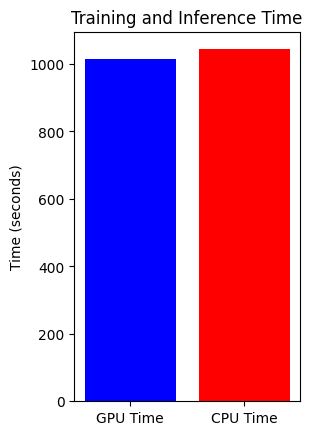

In [29]:
# Plotando o tempo de treinamento e inferência da CPU e GPU
plt.subplot(1, 2, 2)
plt.bar(['GPU Time'], [time_gpu], color=['blue'])
plt.bar(['CPU Time'], [time_cpu], color=['red'])
plt.ylabel('Time (seconds)')
plt.title('Training and Inference Time')

plt.show()

### Matriz de Confusão

A matriz de confusão avalia o desempenho do modelo. Os eixos Y representa as classes verdadeiras (true label) e o eixo x representa as classes previstas (predicted label). Além de indicar a frequência, as cores na matriz representam a intensidade dos valores nas células, ajudando a visualizar a frequência das classificações corretas e incorretas. Quanto mais escuro, mais frequente.

Cada célula na matriz indica o número de vezes que uma classe verdadeira foi prevista como classe específica. Já as células da diagonal principal indicam as instâncias onde o modelo previu corretamente.

#### Interpretação
* A célula (7, 7) tem 142 instâncias, indicando que 142 exemplos da classe 7 foram corretamente classificados como classe 7. Parece ser a classe mais corretamente classificada, com 142 instâncias corretas e poucas confusões com outras classes.

* A célula (11, 11) tem 68 instâncias, indicando que 68 exemplos da classe 11 foram corretamente classificados como classe 11.

* A célula (12, 3) mostra que 3 exemplos da classe 12 foram incorretamente classificados como classe 3.

* A célula (10, 12) mostra que 2 exemplos da classe 10 foram incorretamente classificados como classe 12.

É observado que a classe de índice 12, 16 e 10 mostra uma confusão e que o modelo trabalha bem com as classes 7 e 11. Conclui-se então que as células ao longo da diagonal principal indicam as instâncias onde o modelo previu corretamente a classe e por este motivo se destaca na matriz.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


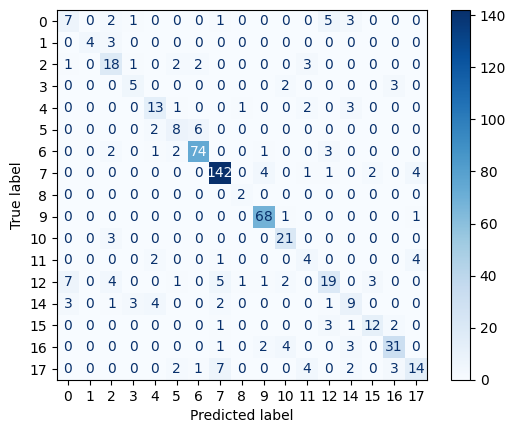

606
              precision    recall  f1-score   support

           0       0.39      0.37      0.38        19
           1       1.00      0.57      0.73         7
           2       0.55      0.67      0.60        27
           3       0.50      0.50      0.50        10
           4       0.59      0.62      0.60        21
           5       0.50      0.50      0.50        16
           6       0.89      0.89      0.89        83
           7       0.89      0.92      0.90       154
           8       0.50      1.00      0.67         2
           9       0.89      0.97      0.93        70
          10       0.70      0.88      0.78        24
          11       0.29      0.36      0.32        11
          12       0.59      0.44      0.51        43
          13       0.00      0.00      0.00         0
          14       0.43      0.36      0.39        25
          15       0.71      0.63      0.67        19
          16       0.79      0.76      0.77        41
          17       0.61

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_classes = classifier.predict(X_test)

# Calcula a matriz de confusão
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

classifier.generate_report(y_test, y_pred_classes)